<a href="https://colab.research.google.com/github/joelkny97/ruhealth2024-team7/blob/develop/RUHealthHackEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:


# Step 1: Load the CSV Files
# Replace the file paths with the actual file locations of the DE-SynPUF data.

beneficiary_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RUHealthHack/DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv")
inpatient_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RUHealthHack/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv")
outpatient_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RUHealthHack/DE1_0_2008_to_2010_Outpatient_Claims_Sample_1.csv",low_memory=False,)
carrier_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RUHealthHack/DE1_0_2008_to_2010_Carrier_Claims_Sample_1A.csv", low_memory=False)





In [16]:
inpatient_df.head()
inpatient_df.describe()

chronic_conditions = [
    'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
    'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
    'SP_RA_OA', 'SP_STRKETIA'
]

,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_ADMSN_DT,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
count,6.677300e+04,66773.000000,6.670500e+04,6.670500e+04,66773.000000,66773.000000,6.610000e+04,3.905800e+04,7.683000e+03,6.677300e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.965017e+14,1.001018,2.008846e+07,2.008861e+07,9573.632756,398.899256,5.046059e+09,5.065150e+09,5.062263e+09,2.008846e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.859526e+11,0.031896,7.587457e+03,7.559295e+03,9315.073232,3663.463023,2.931521e+09,2.930776e+09,2.906374e+09,7.587081e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.960112e+14,1.000000,2.007113e+07,2.008010e+07,-8000.000000,0.000000,1.168381e+06,1.159725e+06,8.363090e+05,2.007113e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.962512e+14,1.000000,2.008081e+07,2.008082e+07,4000.000000,0.000000,2.482526e+09,2.482526e+09,2.559218e+09,2.008081e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.965012e+14,1.000000,2.009032e+07,2.009032e+07,7000.000000,0.000000,4.965742e+09,5.039206e+09,5.015526e+09,2.009032e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.967512e+14,1.000000,2.009111e+07,2.009112e+07,11000.000000,0.000000,7.676245e+09,7.640006e+09,7.585165e+09,2.009111e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.969912e+14,2.000000,2.010123e+07,2.010123e+07,57000.000000,68000.000000,9.999956e+09,9.999602e+09,9.999956e+09,2.010123e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
inpatient_costs = inpatient_df[['DESYNPUF_ID', 'PRVDR_NUM', 'CLM_ID', 'CLM_PMT_AMT']]
outpatient_costs = outpatient_df[['DESYNPUF_ID', 'PRVDR_NUM', 'CLM_ID', 'CLM_PMT_AMT']]

In [22]:
claims_data = pd.concat([inpatient_costs, outpatient_costs])
# Step 1: Itemized Billing Audit - Calculate total and average costs for each claim
itemized_audit = claims_data.groupby(['DESYNPUF_ID', 'CLM_ID']).agg(
    total_claim_cost=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='sum'),
    avg_claim_cost=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='mean')
).reset_index()

print("Itemized Billing Audit Sample:")
print(itemized_audit.head())

Itemized Billing Audit Sample:
        DESYNPUF_ID           CLM_ID  total_claim_cost  avg_claim_cost
0  00013D2EFD8E45D1  196661176988405            4000.0          4000.0
1  00013D2EFD8E45D1  542192281063886              50.0            50.0
2  00016F745862898F  196091176981058            5000.0          5000.0
3  00016F745862898F  196201177000368           26000.0         26000.0
4  00016F745862898F  196261176983265           16000.0         16000.0


In [24]:
hospital_costs = claims_data.groupby('PRVDR_NUM').agg(
    total_hospital_cost=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='sum'),
    avg_claim_cost=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='mean'),
    claim_count=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='count')
).reset_index()

print("\nHospital Cost Comparison Summary:")
print(hospital_costs.head())


Hospital Cost Comparison Summary:
  PRVDR_NUM  total_hospital_cost  avg_claim_cost  claim_count
0    01006H             174980.0     5468.125000           32
1    01006P              74800.0      284.410646          263
2    01006V             752450.0     4324.425287          174
3    01008A              63060.0      313.731343          201
4    01008J             336580.0      250.991797         1341



High-Cost Hospitals (Z-score > 2):
     PRVDR_NUM  total_hospital_cost  avg_claim_cost  claim_count  \
29      0100KT             866960.0     3736.896552          232   
72      0101MC            1097620.0     6991.210191          157   
118     01S1YV             942000.0     9515.151515           99   
144     0300CC            1725040.0     7565.964912          228   
145     0300DD            2029880.0     4461.274725          455   
...        ...                  ...             ...          ...   
6514    5130XG            1451000.0    10669.117647          136   
6535    5200GH            1209650.0     3568.289086          339   
6560    5200WS             839410.0     4304.666667          195   
6563    5200YU             836110.0     1375.180921          608   
6581    5201TA            1611740.0     5538.625430          291   

      total_cost_zscore  
29             2.144911  
72             2.813530  
118            2.362431  
144            4.632244  
145            5.

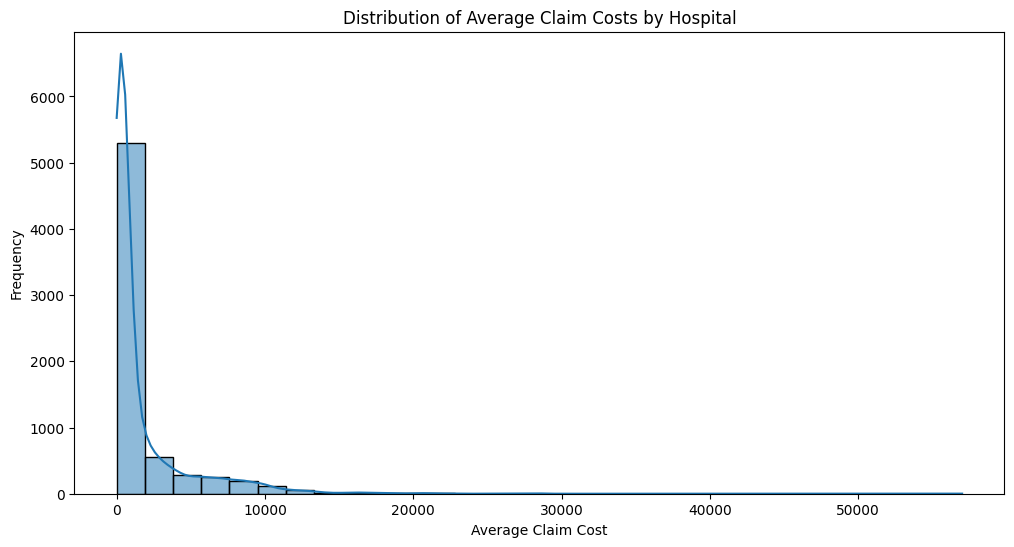

In [28]:
hospital_costs['total_cost_zscore'] = zscore(hospital_costs['total_hospital_cost'])
high_cost_hospitals = hospital_costs[hospital_costs['total_cost_zscore'] > 2]  # Hospitals with z-score > 2

print("\nHigh-Cost Hospitals (Z-score > 2):")
print(high_cost_hospitals)

# Step 4: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of average claim cost by hospital
plt.figure(figsize=(12, 6))
sns.histplot(hospital_costs['avg_claim_cost'], bins=30, kde=True)
plt.xlabel('Average Claim Cost')
plt.ylabel('Frequency')
plt.title("Distribution of Average Claim Costs by Hospital")
plt.show()

<ipython-input-29-90484988a38b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_hospitals, x='PRVDR_NUM', y='total_hospital_cost', palette="viridis")


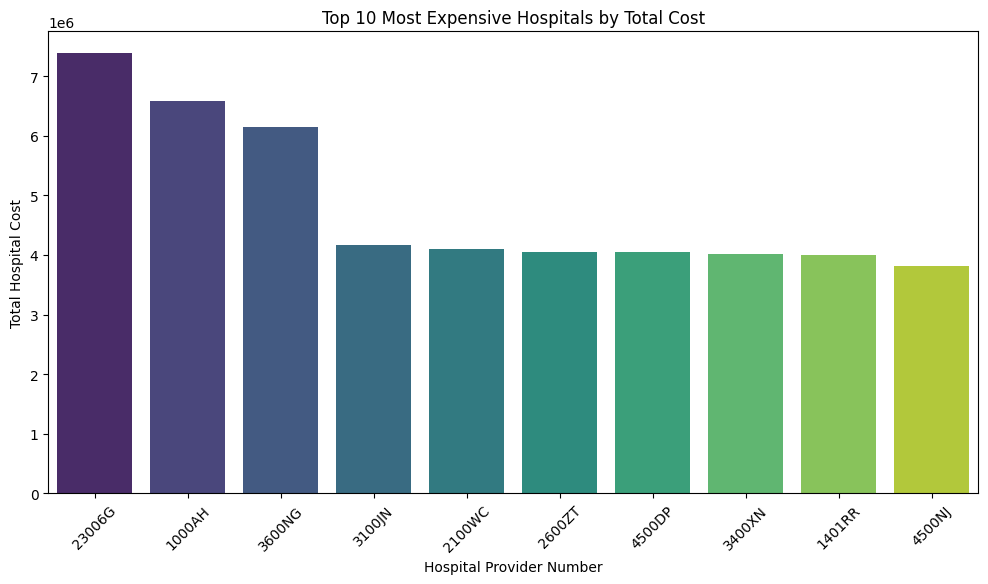

In [29]:
# Top 10 most expensive hospitals by total cost
top_hospitals = hospital_costs.nlargest(10, 'total_hospital_cost')
plt.figure(figsize=(12, 6))
sns.barplot(data=top_hospitals, x='PRVDR_NUM', y='total_hospital_cost', palette="viridis")
plt.xticks(rotation=45)
plt.xlabel('Hospital Provider Number')
plt.ylabel('Total Hospital Cost')
plt.title("Top 10 Most Expensive Hospitals by Total Cost")
plt.show()

Patient Cost Summary:
        DESYNPUF_ID  total_cost  avg_claim_cost  num_claims
0  00013D2EFD8E45D1      4050.0     2025.000000           2
1  00016F745862898F     52060.0     8676.666667           6
2  0001FDD721E223DC        30.0       30.000000           1
3  00024B3D2352D2D0       160.0       40.000000           4
4  0002F28CE057345B      2920.0      153.684211          19


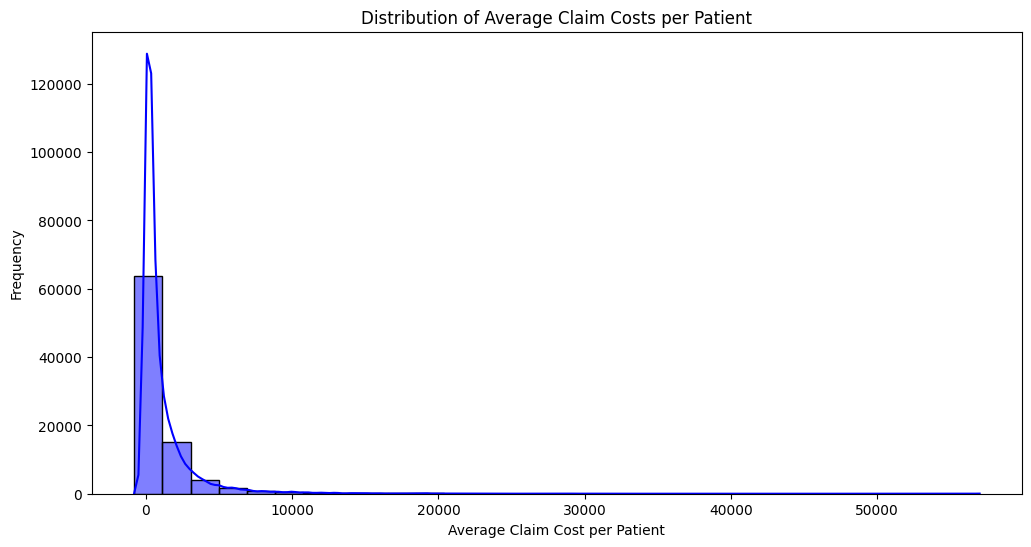


Detected Outliers:
            DESYNPUF_ID  total_cost  avg_claim_cost  num_claims  \
1      00016F745862898F     52060.0     8676.666667           6   
6      000345A39D4157C9       590.0      295.000000           2   
12     0007F12A492FD25D     65470.0     1769.459459          37   
13     000B4662348C35B4     44740.0     1355.757576          33   
15     000C7486B11E7030     30080.0    10026.666667           3   
...                 ...         ...             ...         ...   
86631  FFB5A3FBC31ABA7E     20100.0    10050.000000           2   
86651  FFC2F49B366D43D0       380.0       63.333333           6   
86660  FFC82B5B9C6058BE     10000.0    10000.000000           1   
86672  FFD1CECC7E439A44     77100.0    12850.000000           6   
86702  FFE7C75AE1426A4D      8890.0     1270.000000           7   

       is_outlier_iso  is_outlier_lof  
1                True           False  
6               False            True  
12               True           False  
13             

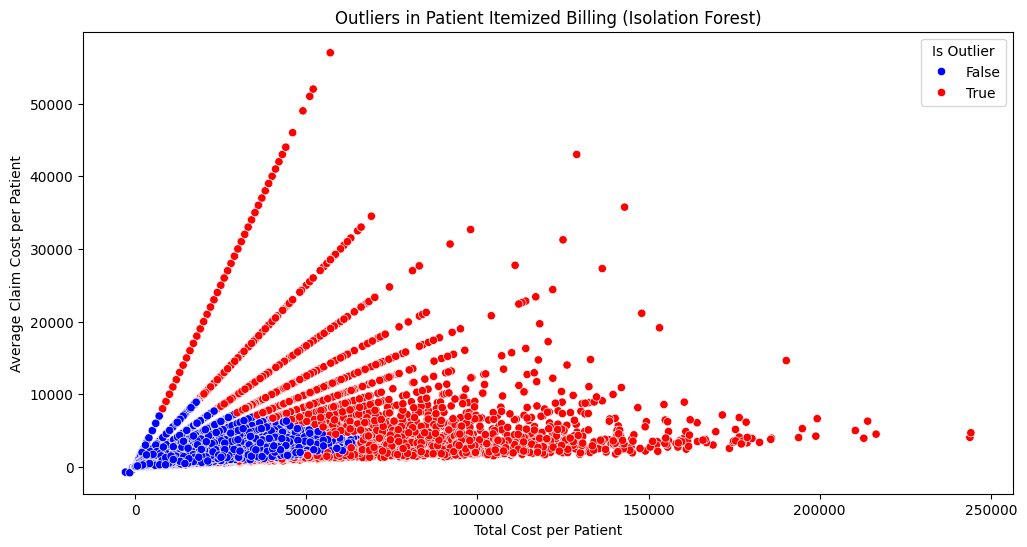


Summary of Outliers:
          total_cost  avg_claim_cost   num_claims
count    8245.000000     8245.000000  8245.000000
mean    34166.255913     4512.695943    13.555488
std     37070.026126     6002.245171    14.718521
min     -2860.000000     -800.000000     1.000000
25%      3080.000000      506.750000     3.000000
50%     16590.000000     2333.333333     6.000000
75%     60260.000000     6415.000000    22.000000
max    244180.000000    57000.000000    79.000000

Summary of Non-Outliers:
         total_cost  avg_claim_cost    num_claims
count  78493.000000    78493.000000  78493.000000
mean    7415.745480      802.997648      9.501459
std    10350.652689     1145.343536      7.705296
min      -40.000000      -40.000000      1.000000
25%      600.000000      121.666667      3.000000
50%     3050.000000      332.727273      8.000000
75%    10160.000000      997.142857     14.000000
max    65500.000000     9050.000000     39.000000


In [31]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns



# Step 1: Prepare Data for Cost Analysis and Outlier Detection
# Select relevant fields
inpatient_costs = inpatient_df[['DESYNPUF_ID', 'PRVDR_NUM', 'CLM_ID', 'CLM_PMT_AMT']]
outpatient_costs = outpatient_df[['DESYNPUF_ID', 'PRVDR_NUM', 'CLM_ID', 'CLM_PMT_AMT']]

# Concatenate inpatient and outpatient data for comprehensive analysis
claims_data = pd.concat([inpatient_costs, outpatient_costs])

# Step 2: Cost Comparison Analysis
# Calculate total and average cost per patient
patient_costs = claims_data.groupby('DESYNPUF_ID').agg(
    total_cost=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='sum'),
    avg_claim_cost=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='mean'),
    num_claims=pd.NamedAgg(column='CLM_ID', aggfunc='count')
).reset_index()

print("Patient Cost Summary:")
print(patient_costs.head())

# Visualize the distribution of average claim cost
plt.figure(figsize=(12, 6))
sns.histplot(patient_costs['avg_claim_cost'], bins=30, kde=True, color='blue')
plt.xlabel('Average Claim Cost per Patient')
plt.ylabel('Frequency')
plt.title("Distribution of Average Claim Costs per Patient")
plt.show()

# Step 3: Scaling Data for Outlier Detection
# Prepare data for modeling by scaling numeric values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(patient_costs[['total_cost', 'avg_claim_cost', 'num_claims']])

# Step 4: Outlier Detection with Isolation Forest
# Initialize Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers_iso = iso_forest.fit_predict(scaled_data)

# Add outlier flags to the patient data
patient_costs['is_outlier_iso'] = outliers_iso == -1

# Step 5: Outlier Detection with Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outliers_lof = lof.fit_predict(scaled_data)

# Add outlier flags to the patient data for LOF
patient_costs['is_outlier_lof'] = outliers_lof == -1

# Step 6: Analyze Outliers
# Filter outliers flagged by both methods
outliers = patient_costs[(patient_costs['is_outlier_iso']) | (patient_costs['is_outlier_lof'])]
print("\nDetected Outliers:")
print(outliers)

# Visualize Outliers vs. Non-Outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(data=patient_costs, x='total_cost', y='avg_claim_cost', hue='is_outlier_iso', palette={0: 'blue', 1: 'red'})
plt.xlabel('Total Cost per Patient')
plt.ylabel('Average Claim Cost per Patient')
plt.title("Outliers in Patient Itemized Billing (Isolation Forest)")
plt.legend(title="Is Outlier")
plt.show()

# Step 7: Compare with Non-Outliers for Audit Insights
# Summarize stats for outliers vs. non-outliers
outliers_summary = outliers[['total_cost', 'avg_claim_cost', 'num_claims']].describe()
non_outliers_summary = patient_costs[~((patient_costs['is_outlier_iso']) | (patient_costs['is_outlier_lof']))][['total_cost', 'avg_claim_cost', 'num_claims']].describe()

print("\nSummary of Outliers:")
print(outliers_summary)

print("\nSummary of Non-Outliers:")
print(non_outliers_summary)


Patient Summary with Readmission Counts:
        DESYNPUF_ID  total_cost  avg_claim_cost  num_claims  SP_CHF  \
0  00013D2EFD8E45D1      4050.0     2025.000000           2       2   
1  00016F745862898F     52060.0     8676.666667           6       2   
2  0001FDD721E223DC        30.0       30.000000           1       2   
3  00024B3D2352D2D0       160.0       40.000000           4       2   
4  0002F28CE057345B      2920.0      153.684211          19       1   

   SP_DIABETES  SP_ISCHMCHT  readmission_count  
0            2            2                0.0  
1            2            2                3.0  
2            2            2                0.0  
3            2            2                0.0  
4            1            1                0.0  

Cost and Readmission Summary by Chronic Condition:
   SP_CHF  SP_DIABETES  SP_ISCHMCHT  avg_total_cost  avg_readmission_rate  \
0       1            1            1    21197.741047              0.967944   
1       1            1          

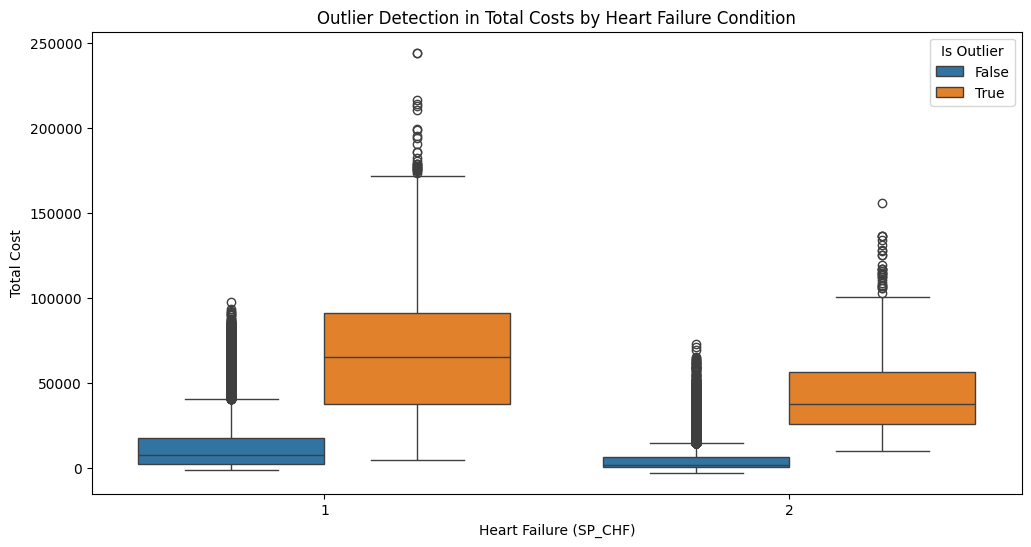

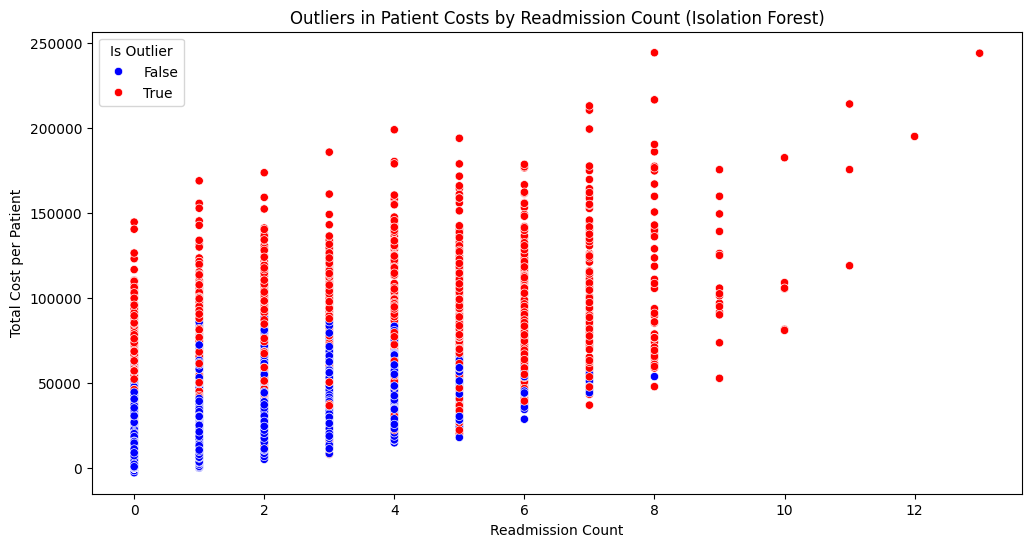


Outliers Summary:
          total_cost  avg_claim_cost   num_claims  readmission_count
count    7971.000000     7971.000000  7971.000000        7971.000000
mean    33357.548614     4154.477698    13.510225           1.249655
std     36716.246633     6065.975489    14.232228           1.874721
min     -2860.000000     -800.000000     1.000000           0.000000
25%      1710.000000      315.775862     3.000000           0.000000
50%     22000.000000     1947.659574     7.000000           0.000000
75%     56760.000000     5501.250000    21.000000           2.000000
max    244180.000000    57000.000000    79.000000          13.000000

Non-Outliers Summary:
         total_cost  avg_claim_cost    num_claims  readmission_count
count  78767.000000    78767.000000  78767.000000       78767.000000
mean    7590.639100      852.152941      9.520142           0.240761
std    10998.002081     1286.927770      7.838173           0.690126
min        0.000000        0.000000      1.000000           0

In [32]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Merge and Prepare Data
# Combine inpatient and outpatient data, merging with beneficiary data on `DESYNPUF_ID`
claims_data = pd.concat([inpatient_df[['DESYNPUF_ID', 'PRVDR_NUM', 'CLM_ID', 'CLM_PMT_AMT']],
                         outpatient_df[['DESYNPUF_ID', 'PRVDR_NUM', 'CLM_ID', 'CLM_PMT_AMT']]])
claims_data = claims_data.merge(beneficiary_df[['DESYNPUF_ID', 'SP_CHF', 'SP_DIABETES', 'SP_ISCHMCHT']],
                                on='DESYNPUF_ID', how='left')

# Step 2: Aggregate Costs and Calculate Readmission Rates
# Calculate total cost, average cost, and claim count per patient
patient_summary = claims_data.groupby('DESYNPUF_ID').agg(
    total_cost=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='sum'),
    avg_claim_cost=pd.NamedAgg(column='CLM_PMT_AMT', aggfunc='mean'),
    num_claims=pd.NamedAgg(column='CLM_ID', aggfunc='count')
).reset_index()

# Add chronic conditions from beneficiary data to patient summary
patient_summary = patient_summary.merge(beneficiary_df[['DESYNPUF_ID', 'SP_CHF', 'SP_DIABETES', 'SP_ISCHMCHT']],
                                        on='DESYNPUF_ID', how='left')

# Define a readmission flag for patients with multiple inpatient claims within 30 days
inpatient_df['CLM_FROM_DT'] = pd.to_datetime(inpatient_df['CLM_FROM_DT'])
inpatient_df = inpatient_df.sort_values(by=['DESYNPUF_ID', 'CLM_FROM_DT'])
inpatient_df['readmission'] = inpatient_df.groupby('DESYNPUF_ID')['CLM_FROM_DT'].diff().dt.days.le(30).astype(int)
readmission_rates = inpatient_df.groupby('DESYNPUF_ID')['readmission'].sum().reset_index()
readmission_rates.rename(columns={'readmission': 'readmission_count'}, inplace=True)

# Merge readmission counts back into patient summary
patient_summary = patient_summary.merge(readmission_rates, on='DESYNPUF_ID', how='left')
patient_summary['readmission_count'] = patient_summary['readmission_count'].fillna(0)

print("Patient Summary with Readmission Counts:")
print(patient_summary.head())

# Step 3: Cost Comparison by Chronic Condition
# Group by chronic conditions and calculate average costs and readmission rates
condition_summary = patient_summary.groupby(['SP_CHF', 'SP_DIABETES', 'SP_ISCHMCHT']).agg(
    avg_total_cost=pd.NamedAgg(column='total_cost', aggfunc='mean'),
    avg_readmission_rate=pd.NamedAgg(column='readmission_count', aggfunc='mean'),
    avg_num_claims=pd.NamedAgg(column='num_claims', aggfunc='mean')
).reset_index()

print("\nCost and Readmission Summary by Chronic Condition:")
print(condition_summary)

# Step 4: Outlier Detection Model - Include Chronic Conditions and Readmission Rates
# Prepare data for outlier detection
features = ['total_cost', 'avg_claim_cost', 'num_claims', 'SP_CHF', 'SP_DIABETES', 'SP_ISCHMCHT', 'readmission_count']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(patient_summary[features])

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
patient_summary['is_outlier_iso'] = iso_forest.fit_predict(scaled_features) == -1

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
patient_summary['is_outlier_lof'] = lof.fit_predict(scaled_features) == -1

# Step 5: Analyze Outliers
outliers = patient_summary[(patient_summary['is_outlier_iso']) | (patient_summary['is_outlier_lof'])]
print("\nDetected Outliers with Chronic Conditions and Readmission Count:")
print(outliers)

# Step 6: Visualization of Cost by Chronic Condition
plt.figure(figsize=(12, 6))
sns.boxplot(data=patient_summary, x='SP_CHF', y='total_cost', hue='is_outlier_iso')
plt.xlabel('Heart Failure (SP_CHF)')
plt.ylabel('Total Cost')
plt.title("Outlier Detection in Total Costs by Heart Failure Condition")
plt.legend(title="Is Outlier")
plt.show()

# Step 7: Visualize Readmission Rate vs. Total Cost
plt.figure(figsize=(12, 6))
sns.scatterplot(data=patient_summary, x='readmission_count', y='total_cost', hue='is_outlier_iso', palette={0: 'blue', 1: 'red'})
plt.xlabel('Readmission Count')
plt.ylabel('Total Cost per Patient')
plt.title("Outliers in Patient Costs by Readmission Count (Isolation Forest)")
plt.legend(title="Is Outlier")
plt.show()

# Summary comparison of costs and readmission by chronic condition
outliers_summary = outliers[['total_cost', 'avg_claim_cost', 'num_claims', 'readmission_count']].describe()
non_outliers_summary = patient_summary[~((patient_summary['is_outlier_iso']) | (patient_summary['is_outlier_lof']))][['total_cost', 'avg_claim_cost', 'num_claims', 'readmission_count']].describe()

print("\nOutliers Summary:")
print(outliers_summary)
print("\nNon-Outliers Summary:")
print(non_outliers_summary)


Remaining features after removing highly correlated and high VIF features: Index(['CLM_PMT_AMT'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.353949
         Iterations 6

Logistic Regression Model Summary (Predictors of Readmission by Chronic Condition):
                           Logit Regression Results                           
Dep. Variable:      readmission_label   No. Observations:               600294
Model:                          Logit   Df Residuals:                   600292
Method:                           MLE   Df Model:                            1
Date:                Sat, 26 Oct 2024   Pseudo R-squ.:               0.0006342
Time:                        22:33:53   Log-Likelihood:            -2.1247e+05
converged:                       True   LL-Null:                   -2.1261e+05
Covariance Type:            nonrobust   LLR p-value:                 1.345e-60
                  coef    std err          z      P>|z|      [0.025

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-12-ea7c4e449024>:87: FutureWarning

              precision    recall  f1-score   support

       False       0.00      0.00      0.00     29775
        True       0.88      1.00      0.94    227494

    accuracy                           0.88    257269
   macro avg       0.44      0.50      0.47    257269
weighted avg       0.78      0.88      0.83    257269

AUC Score: 0.50

Feature Importances from Decision Tree:
       feature  importance
0  CLM_PMT_AMT         1.0


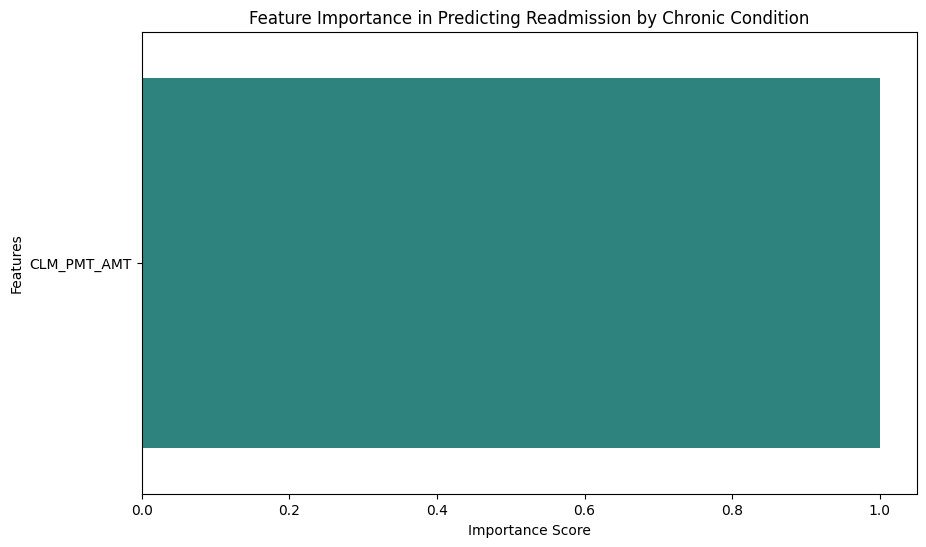

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Step 1: Merge Chronic Conditions with Claim Data
# Include all relevant chronic condition indicators in the beneficiary data
chronic_conditions = [
    'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
    'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
    'SP_RA_OA', 'SP_STRKETIA'
]

# Concatenate inpatient and outpatient claims with unique IDs
claims_data = pd.concat([inpatient_df[['DESYNPUF_ID', 'CLM_ID', 'CLM_PMT_AMT', 'CLM_FROM_DT']],
                         outpatient_df[['DESYNPUF_ID', 'CLM_ID', 'CLM_PMT_AMT', 'CLM_FROM_DT']]])
claims_data['CLM_FROM_DT'] = pd.to_datetime(claims_data['CLM_FROM_DT'])

# Merge chronic conditions with claims data
claims_data = claims_data.merge(beneficiary_df[['DESYNPUF_ID'] + chronic_conditions], on='DESYNPUF_ID', how='left')

# Step 2: Calculate Readmission Label for Each Claim
# Sort claims and flag readmissions based on 30-day difference
claims_data = claims_data.sort_values(by=['DESYNPUF_ID', 'CLM_FROM_DT'])
claims_data['readmission'] = claims_data.groupby('DESYNPUF_ID')['CLM_FROM_DT'].diff().dt.days.le(30).fillna(0).astype(int)

# Add readmission label as a binary flag for each claim
claims_data['readmission_label'] = claims_data['readmission'] > 0

# Prepare dataset for model with chronic conditions, individual claim costs, and readmission labels

X = claims_data[chronic_conditions + ['CLM_PMT_AMT']]
y = claims_data['readmission_label']

# Calculate correlation matrix
corr_matrix = X.corr().abs()

# Remove highly correlated features (threshold > 0.9)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
X = X.drop(columns=high_corr_features)

# Calculate VIF and remove features with VIF > 10
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
X = X.drop(columns=high_vif_features)

# Print remaining features after collinearity check
print("Remaining features after removing highly correlated and high VIF features:", X.columns)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Logistic Regression to Identify Significant Predictors
X_train_const = sm.add_constant(X_train)  # Add constant for intercept
log_reg_model = sm.Logit(y_train, X_train_const).fit()

print("\nLogistic Regression Model Summary (Predictors of Readmission by Chronic Condition):")
print(log_reg_model.summary())

# Step 5: Decision Tree for Feature Importance Analysis
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = tree_model.predict(X_test)
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_pred):.2f}")

# Feature Importance from Decision Tree
importances = pd.DataFrame({'feature': X.columns, 'importance': tree_model.feature_importances_}).sort_values(by='importance', ascending=False)
print("\nFeature Importances from Decision Tree:")
print(importances)

# Visualization of Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature', palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting Readmission by Chronic Condition")
plt.show()
